
# 1 神经网络

## 1.1 显示数据 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
#加载数据
data = loadmat('ex4data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

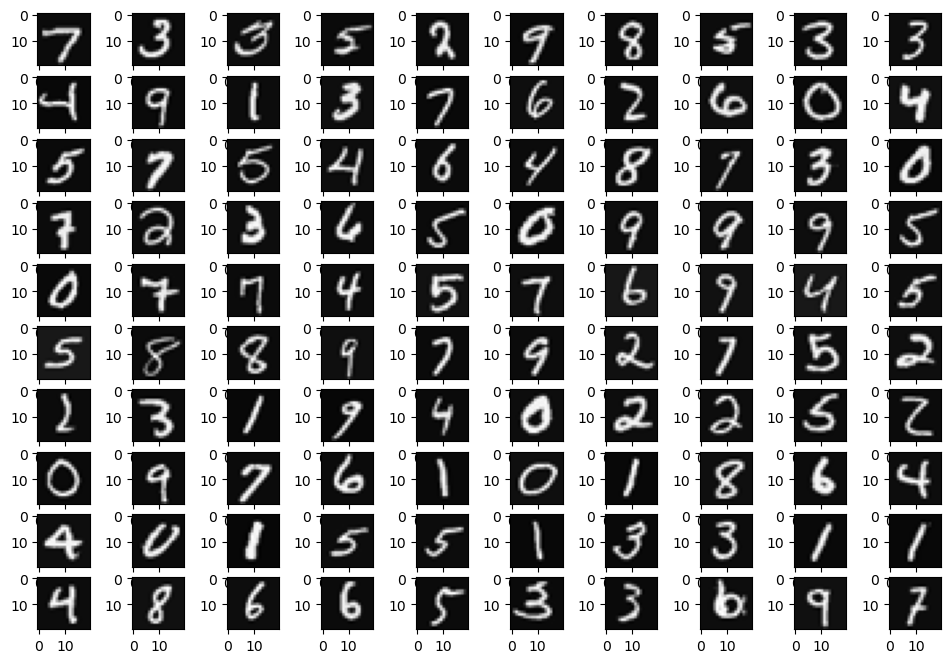

In [3]:
#显示随机100个训练样本数据
nums = np.random.randint(0,5001,100)
fig,ax = plt.subplots(10,10,figsize=(12,8))

def generateImg(mums):
    for i in mums:
        img = data['X'][i].reshape(20,20).T
        #注释掉单通道变三通道的灰度图
        #imgofthree = np.concatenate((np.expand_dims(img, axis=2), 
        #                                         np.expand_dims(img, axis=2), 
        #                                        np.expand_dims(img, axis=2)), axis=2)
        yield img


generate = generateImg(nums)
for r in range(10):
     for c in range(10):
        ax[r][c].imshow(next(generate),cmap='gray')
plt.show()

In [4]:
#创建有用的变量
X =data['X']
y = data['y']
X.shape,y.shape

((5000, 400), (5000, 1))

In [5]:
#one-hot
"""
    将类标签n（k类）转换为长度为k的向量，
    其中索引n为“hot”（1），而其余为0。
"""
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse = False)
y_onehot = encoder.fit_transform(y)
y_onehot.shape

(5000, 10)

In [6]:
y[0],y_onehot[0,:]

(array([10], dtype=uint8), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

## 1.2 模型表示

In [7]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

### 网络图示
> (400 + 1) -> (25 + 1) -> (10)

<img style="float: left;" src="../img/nn_model.png">

## 1.3 前向传播和代价函数

In [8]:
def forward_propagate(X,theta1,theta2):
    """
        前向传播函数
    """
    m = X.shape[0]
    
    a1 = np.insert(X,0,values=np.ones(m),axis=1)
    z2= a1 * theta1.T
    #有几个样本就有几个a2行，插入m个1
    a2 = np.insert(sigmoid(z2),0,values=np.ones(m),axis=1)
    z3 = a2 * theta2.T
    h = sigmoid(z3)
    
    return a1,z2,a2,z3,h    

<img style="float: left;" src="../img/nn_cost.png">

In [9]:
def cost(params, input_size, hidden_size, num_labels, X, y):
    """
        无正则项的神经网络代价函数
        params 网络中的所有参数展开排列
        input_size 输入维度
        hidden_size 隐藏层神经元个数
        num_labels  K预测种类
    """
    m = X.shape[0]
    X=np.matrix(X)
    #这里面是y_onehot
    y=np.matrix(y)
    
    theta1 = np.matrix(np.reshape(params[:hidden_size*(input_size +1)],(hidden_size,(input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size*(input_size+1):],(num_labels,(hidden_size +1))))
  
    #这里主要使用h用于求代价
    a1,z2,a2,z3,h=forward_propagate(X,theta1,theta2)
    
    #计算损失
    J = 0
    for i in range(m):
        #y是行向量，h也是行向量表示所有样本预测完的K个结果
        first_term = np.multiply(-y[i,:],np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J+= np.sum(first_term - second_term)
    J = J / m
    return J

In [10]:
#初始化设置
input_size = 400
hidden_size = 25
num_labels = 10
learning_rate = 1

#这个就是2.2随机初始化
params = (np.random.random( size=hidden_size * (input_size + 1) + num_labels * (hidden_size + 1) ) - 0.5) * 0.25
# 将参数数组解开为每个层的参数矩阵
theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

theta1.shape, theta2.shape

((25, 401), (10, 26))

In [11]:
a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
a1.shape, z2.shape, a2.shape, z3.shape, h.shape

((5000, 401), (5000, 25), (5000, 26), (5000, 10), (5000, 10))

In [12]:
cost(params, input_size, hidden_size, num_labels, X, y_onehot)

6.938154054087158

In [13]:
#调用作业里给的权重计算的代价函数
weights = loadmat('ex4weights.mat')
params2 = np.concatenate((weights['Theta1'].flatten(),weights['Theta2'].flatten()),axis=0)
cost(params2, input_size, hidden_size, num_labels, X, y_onehot)

0.2876291651613187

## 1.4 正则化代价函数

<img style="float: left;" src="../img/nn_regcost.png">

In [14]:
def costReg(params, input_size, hidden_size, num_labels, X, y,learning_rate):
    """
        正则化代价函数
        params 网络中的所有参数展开排列
        input_size 输入维度
        hidden_size 隐藏层神经元个数
        num_labels  K预测种类
    """
    m = X.shape[0]
    X=np.matrix(X)
    #这里面是y_onehot
    y=np.matrix(y)
    
    theta1 = np.matrix(np.reshape(params[:hidden_size*(input_size +1)],(hidden_size,(input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size*(input_size+1):],(num_labels,(hidden_size +1))))
  
    #这里主要使用h用于求代价
    a1,z2,a2,z3,h=forward_propagate(X,theta1,theta2)
    
    #计算损失
    J = 0
    for i in range(m):
        #y是行向量，h也是行向量表示所有样本预测完的K个结果
        first_term = np.multiply(-y[i,:],np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J+= np.sum(first_term - second_term)
    J = J / m
    
    #只需添加正则项即可
    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    
    return J

In [15]:
costReg(params2, input_size, hidden_size, num_labels, X, y_onehot,1)

0.3837698590909234

# 2 反向传播算法

## 2.1 sigmoid 导数函数

In [16]:
def sigmoid_gradient(z):
    #向量和矩阵都可以用
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

In [17]:
sigmoid_gradient(0),sigmoid_gradient(100),sigmoid_gradient(-100),

(0.25, 0.0, 3.7200759760208356e-44)

## 2.2 随机初始化

In [18]:
#初始化的参数，让其在-epsilon_init 到 epsilon_init之间
epsilon_init = 0.12
params_init = (np.random.random(size=hidden_size * (input_size + 1) + num_labels * (hidden_size + 1)) * 2 * epsilon_init) - epsilon_init
params_init.shape

(10285,)

## 2.3 BP反向传播算法

In [19]:
def backprop(params,input_size,hidden_size,num_labels,X,y):
    """
        正则化代价函数
        params 网络中的所有参数展开排列,theta的扁平
        input_size 输入样本的维度，特征数=X的列数目
        hidden_size 隐藏层神经元个数
        num_labels  K预测种类
        X 训练集输入
        y 训练集的结果集执行onehot
    """
    m=X.shape[0]
    X=np.matrix(X)
    y=np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
     # initializations
    J=0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
     # compute the cost
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    

    # perform backpropagation
    for t in range(m):
        #第一步
        a1t = a1[t,:] # (1, 401)
        z2t = z2[t,:] # (1, 25)
        a2t = a2[t,:] # (1, 26)
        ht = h[t,:] # (1, 10)
        yt = y[t,:] # (1, 10)
        #第二步
        d3t = ht -yt #(1,10)
        #第三步
        z2t = np.insert(z2t,0,values = np.ones(1)) #(1,26)
        d2t =np.multiply( (theta2.T*d3t.T).T,sigmoid_gradient(z2t)  ) #(1,26)
        
        #第四步
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t
        
    #第五步
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    grad = np.concatenate((np.ravel(delta1),np.ravel(delta2)))
    
    return J, grad


In [20]:
J,grad = backprop(params, input_size, hidden_size, num_labels, X, y_onehot)
J,grad.shape

(6.943454763077094, (10285,))

## 2.4 梯度检测

J对于theta1、theta2中的的每个参数的偏导数是由反向传播算法得来的，为了验证其有效性，可以扁平化（theta1,theta2），然后对比J对于每个参数的BP求出来的偏导数，是否与数值导数相近。

数值导数的求法见ex4-2.4

## 2.5 正则化BP反向传播算法

In [21]:
def backpropReg(params,input_size,hidden_size,num_labels,X,y,learning_rate):
    """
        正则化代价函数
        params 网络中的所有参数展开排列,theta的扁平
        input_size 输入样本的维度，特征数=X的列数目
        hidden_size 隐藏层神经元个数
        num_labels  K预测种类
        X 训练集输入
        y 训练集的结果集执行onehot
    """
    m=X.shape[0]
    X=np.matrix(X)
    y=np.matrix(y)
    
    # reshape the parameter array into parameter matrices for each layer
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    
    # run the feed-forward pass
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
     # initializations
    J=0
    delta1 = np.zeros(theta1.shape)  # (25, 401)
    delta2 = np.zeros(theta2.shape)  # (10, 26)
    
    # compute the cost
    for i in range(m):
        first_term = np.multiply(-y[i,:], np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]), np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    
    J = J / m
    
    # add the cost regularization term
    J += (float(learning_rate) / (2 * m)) * (np.sum(np.power(theta1[:,1:], 2)) + np.sum(np.power(theta2[:,1:], 2)))
    
    
    # perform backpropagation
    for t in range(m):
        #第一步
        a1t = a1[t,:] # (1, 401)
        z2t = z2[t,:] # (1, 25)
        a2t = a2[t,:] # (1, 26)
        ht = h[t,:] # (1, 10)
        yt = y[t,:] # (1, 10)
        #第二步
        d3t = ht -yt #(1,10)
        #第三步
        z2t = np.insert(z2t,0,values = np.ones(1)) #(1,26)
        d2t =np.multiply( (theta2.T*d3t.T).T,sigmoid_gradient(z2t)  ) #(1,26)
        
        #第四步
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t
        
    #第五步
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    # add the gradient regularization term
    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * learning_rate) / m
    delta2[:,1:] = delta2[:,1:] + (theta2[:,1:] * learning_rate) / m
    
    grad = np.concatenate((np.ravel(delta1),np.ravel(delta2)))
    
    return J,grad


In [22]:
J,grad = backpropReg(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)
J,grad.shape

(6.943454763077094, (10285,))

## 2.6 训练参数

In [23]:
from scipy.optimize import minimize

# minimize the objective function
fmin = minimize(fun=backpropReg, x0=params_init, args=(input_size, hidden_size, num_labels, X, y_onehot, learning_rate), 
                method='TNC', jac=True, options={'maxfun': 250})
fmin

     fun: 0.33830747871845124
     jac: array([ 2.20480939e-04, -1.11187024e-06, -1.26005548e-06, ...,
        1.17174295e-05,  2.14745323e-05,  3.87604475e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 21
  status: 3
 success: False
       x: array([ 0.64266571, -0.00555935, -0.00630028, ...,  2.7228573 ,
       -0.23432251, -1.64066024])

In [24]:
# 用得到的参数做预测
X = np.matrix(X)
theta1 = np.matrix(np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
y_pred = np.array(np.argmax(h, axis=1) + 1)
y_pred 

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=int64)

In [25]:
#计算准确率
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print ('accuracy = {0}%'.format(accuracy * 100))

accuracy = 99.28%


# 3 可视化隐藏单元

将参数矩阵theta1消去偏置项，变成400 * 25，然后按照行生成图片，共计25张，表示隐藏单元捕获的标识